 ## **Multi-Layer Perceptron (MLP) Depth Analysis on Fashion-MNIST**:
#
# **Objective:** To explore how the depth of a Multi-Layer Perceptron (MLP) affects performance, training time, and model capacity.  
# **Dataset:** Fashion-MNIST (10 classes of fashion items)  
# **Framework:** PyTorch  
# **Models:** Shallow, Medium, and Deep MLPs

## **1. Imports and Environment Setup**
# We import all necessary libraries including PyTorch, torchvision, matplotlib, seaborn, and sklearn.  
# We also create a folder for storing figures.


In [1]:
import os, time, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, accuracy_score

print('PyTorch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())

# Create folders for figures
os.makedirs('figures', exist_ok=True)

PyTorch version: 2.9.0+cu126
CUDA available: False


## **2. Configuration**
# Define device, random seeds, batch size, number of epochs, learning rate, input/output dimensions, and plotting palette.


In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

BATCH_SIZE = 128
NUM_WORKERS = 2
NUM_EPOCHS = 25
LEARNING_RATE = 1e-3
INPUT_DIM = 28*28
NUM_CLASSES = 10

# Colorblind-friendly palette for plots
PALETTE = ['#0072B2', '#E69F00', '#009E73']

#  **3. Dataset and DataLoaders**
# Load the Fashion-MNIST dataset and split it into training, validation, and test sets.  
# Normalize images to mean 0.5 and std 0.5.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

# Split training set into train/validation
val_size = 5000
train_size = len(train_dataset) - val_size
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f'Train size: {len(train_set)}, Val size: {len(val_set)}, Test size: {len(test_dataset)}')


100%|██████████| 26.4M/26.4M [00:01<00:00, 19.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 305kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.64MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.0MB/s]

Train size: 55000, Val size: 5000, Test size: 10000


# **4. Utility Functions**
# Functions for flattening batches, training one epoch, evaluating, and computing metrics.


In [4]:
def flatten_batch(x):
    return x.view(x.size(0), -1)

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = flatten_batch(inputs).to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += inputs.size(0)
    return running_loss/total, correct/total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = flatten_batch(inputs).to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()*inputs.size(0)
            preds = outputs.argmax(1)
            correct += (preds==labels).sum().item()
            total += inputs.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return running_loss/total, correct/total, all_preds, all_labels

# **5. MLP Model Definitions**
# Define a base MLP and a classifier that can be shallow, medium, or deep.


In [5]:
class MLPBase(nn.Module):
    def __init__(self, layer_sizes, dropout=0.0, batchnorm=False):
        super().__init__()
        layers = []
        for i in range(len(layer_sizes)-1):
            in_dim, out_dim = layer_sizes[i], layer_sizes[i+1]
            layers.append(nn.Linear(in_dim, out_dim))
            if i < len(layer_sizes)-1:
                if batchnorm:
                    layers.append(nn.BatchNorm1d(out_dim))
                layers.append(nn.ReLU(inplace=True))
                if dropout>0:
                    layers.append(nn.Dropout(dropout))
        self.net = nn.Sequential(*layers)
    def forward(self,x):
        return self.net(x)

class MLPClassifier(nn.Module):
    def __init__(self, hidden_sizes, dropout=0.0, batchnorm=False):
        super().__init__()
        layers = [INPUT_DIM]+hidden_sizes+[NUM_CLASSES]
        self.mlp = MLPBase(layers, dropout=dropout, batchnorm=batchnorm)
    def forward(self,x):
        return self.mlp(x)

# **6. Build Models**
# - **Shallow:** 1 hidden layer  
# - **Medium:** 3 hidden layers with dropout and batchnorm  
# - **Deep:** 6 hidden layers with higher dropout and batchnorm  


In [6]:
shallow = MLPClassifier([128], dropout=0.0, batchnorm=False).to(DEVICE)
medium = MLPClassifier([128,256,128], dropout=0.2, batchnorm=True).to(DEVICE)
deep = MLPClassifier([256,256,128,128,64,64], dropout=0.3, batchnorm=True).to(DEVICE)

print('Shallow:', shallow)
print('Medium:', medium)
print('Deep:', deep)

Shallow: MLPClassifier(
  (mlp): MLPBase(
    (net): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=10, bias=True)
      (3): ReLU(inplace=True)
    )
  )
)
Medium: MLPClassifier(
  (mlp): MLPBase(
    (net): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=128, out_features=256, bias=True)
      (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=256, out_features=128, bias=True)
      (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Dropout(p=0.2, inpl

## **7. Training Loop**
# Function to train, validate, and save best model weights.


In [7]:
def run_experiment(model, name, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE):
    model = copy.deepcopy(model).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        v_loss, v_acc, _, _ = evaluate(model, val_loader, criterion, DEVICE)
        history['train_loss'].append(t_loss)
        history['train_acc'].append(t_acc)
        history['val_loss'].append(v_loss)
        history['val_acc'].append(v_acc)
        if v_acc>best_val_acc:
            best_val_acc = v_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print(f"[{name}] Epoch {epoch+1}/{num_epochs} - train_acc: {t_acc:.4f}, val_acc: {v_acc:.4f}")

    elapsed = time.time()-start_time
    model.load_state_dict(best_model_wts)
    test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, DEVICE)
    print(f"[{name}] Finished | Test Acc: {test_acc:.4f} | Time: {elapsed:.1f}s")

    return {'name':name,'history':history,'test_loss':test_loss,'test_acc':test_acc,
            'test_preds':test_preds,'test_labels':test_labels,'train_time_s':elapsed,
            'model_state_dict':model.state_dict()}

## **8. Run Experiments**
# Train and evaluate all three models.


In [8]:
results_shallow = run_experiment(shallow,'Shallow')
results_medium = run_experiment(medium,'Medium')
results_deep = run_experiment(deep,'Deep')

[Shallow] Epoch 1/25 - train_acc: 0.7039, val_acc: 0.7362
[Shallow] Epoch 2/25 - train_acc: 0.7334, val_acc: 0.7420
[Shallow] Epoch 3/25 - train_acc: 0.7390, val_acc: 0.7460
[Shallow] Epoch 4/25 - train_acc: 0.7447, val_acc: 0.7470
[Shallow] Epoch 5/25 - train_acc: 0.7483, val_acc: 0.7554
[Shallow] Epoch 6/25 - train_acc: 0.7511, val_acc: 0.7478
[Shallow] Epoch 7/25 - train_acc: 0.7530, val_acc: 0.7430
[Shallow] Epoch 8/25 - train_acc: 0.7555, val_acc: 0.7546
[Shallow] Epoch 9/25 - train_acc: 0.7574, val_acc: 0.7544
[Shallow] Epoch 10/25 - train_acc: 0.7589, val_acc: 0.7536
[Shallow] Epoch 11/25 - train_acc: 0.7606, val_acc: 0.7540
[Shallow] Epoch 12/25 - train_acc: 0.7622, val_acc: 0.7582
[Shallow] Epoch 13/25 - train_acc: 0.7628, val_acc: 0.7596
[Shallow] Epoch 14/25 - train_acc: 0.7638, val_acc: 0.7522
[Shallow] Epoch 15/25 - train_acc: 0.7652, val_acc: 0.7538
[Shallow] Epoch 16/25 - train_acc: 0.7662, val_acc: 0.7564
[Shallow] Epoch 17/25 - train_acc: 0.7671, val_acc: 0.7606
[Shall

# **9. Plot Learning Curves**
# Visualize training and validation accuracy & loss for all models.


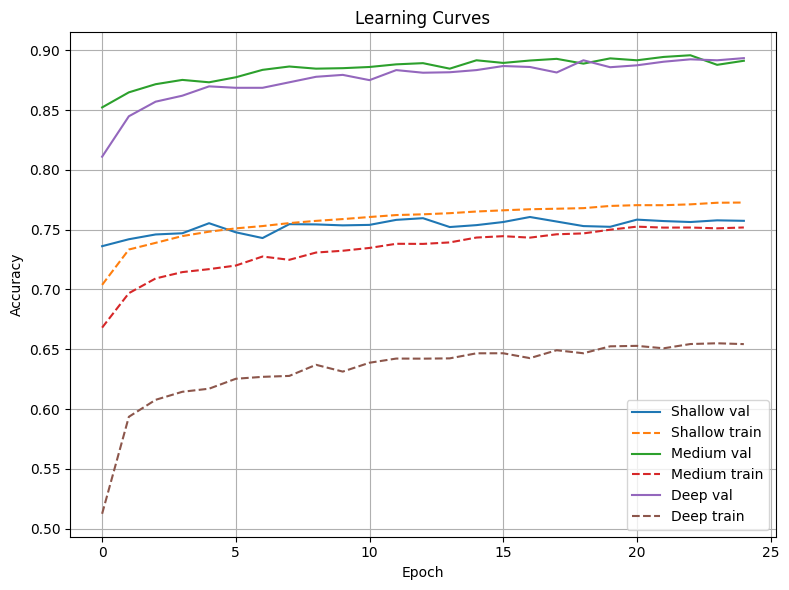

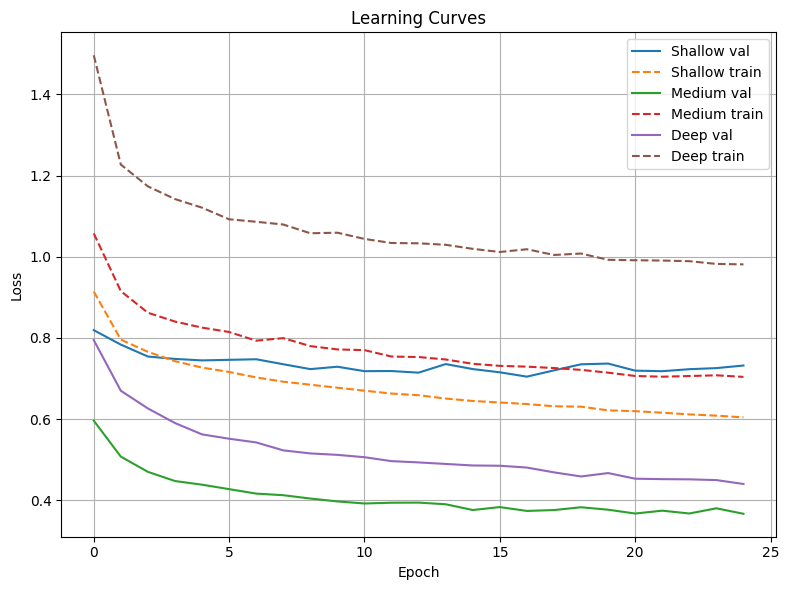

In [9]:
def plot_learning_curves(res_list, metric='acc'):
    plt.figure(figsize=(8,6))
    for res in res_list:
        h = res['history']
        y_train = h['train_acc'] if metric=='acc' else h['train_loss']
        y_val = h['val_acc'] if metric=='acc' else h['val_loss']
        plt.plot(y_val,label=f"{res['name']} val",linestyle='-')
        plt.plot(y_train,label=f"{res['name']} train",linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy' if metric=='acc' else 'Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"figures/{metric}_comparison.png", dpi=200)
    plt.show()

plot_learning_curves([results_shallow, results_medium, results_deep],'acc')
plot_learning_curves([results_shallow, results_medium, results_deep],'loss')


# **10. Confusion Matrices**
# Analyze performance per class.


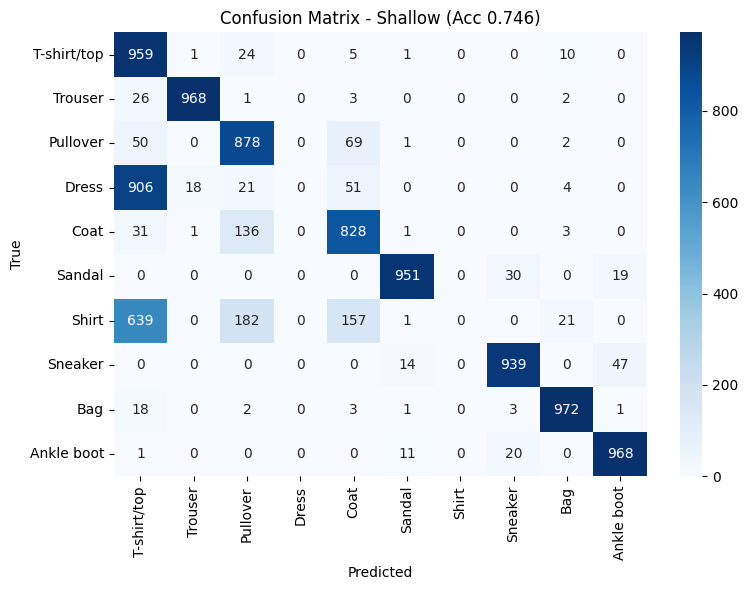

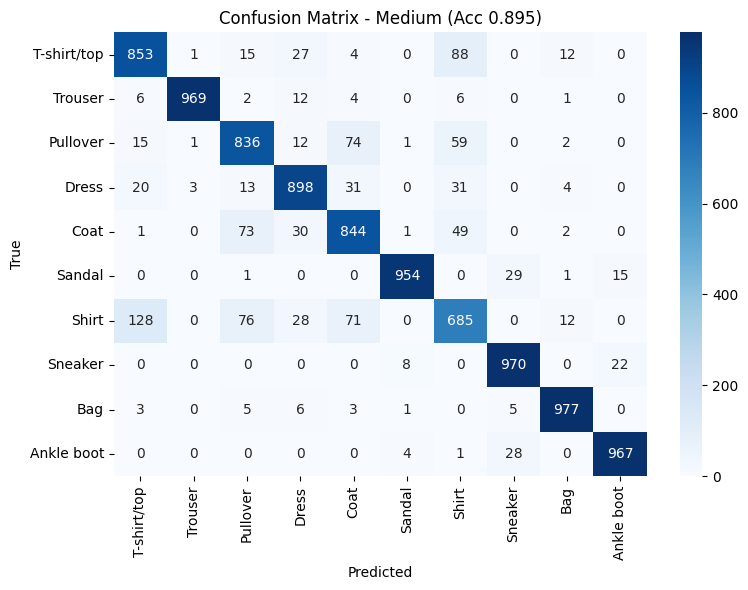

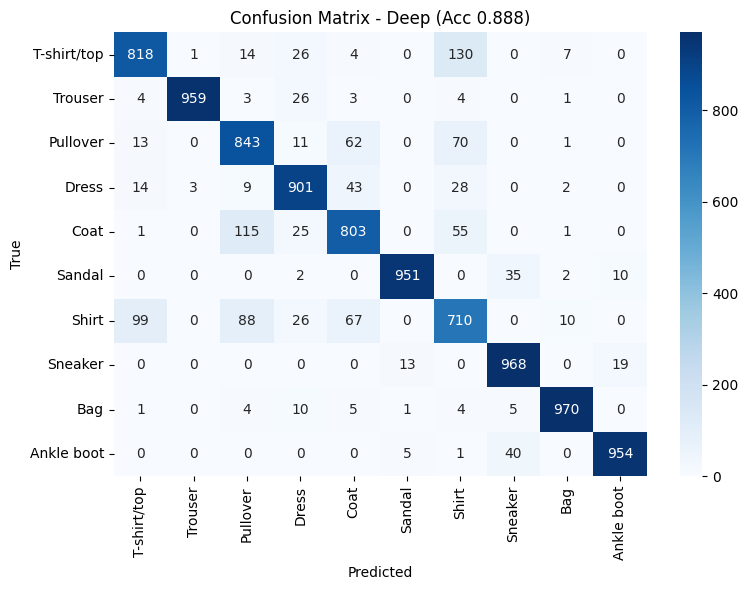

In [10]:
def plot_confusion(res, class_names=None):
    cm = confusion_matrix(res['test_labels'], res['test_preds'])
    if class_names is None:
        class_names = [str(i) for i in range(NUM_CLASSES)]
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.title(f"Confusion Matrix - {res['name']} (Acc {res['test_acc']:.3f})")
    plt.tight_layout()
    plt.savefig(f"figures/confusion_{res['name'].lower()}.png", dpi=200)
    plt.show()

class_names = train_dataset.classes
for res in [results_shallow, results_medium, results_deep]:
    plot_confusion(res,class_names)

# **11. Misclassified Examples**
# Show 10 misclassified examples per model.


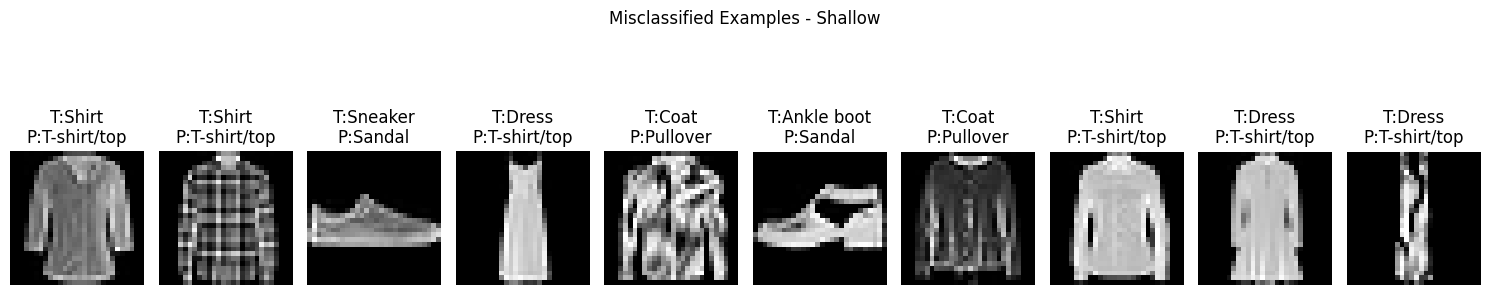

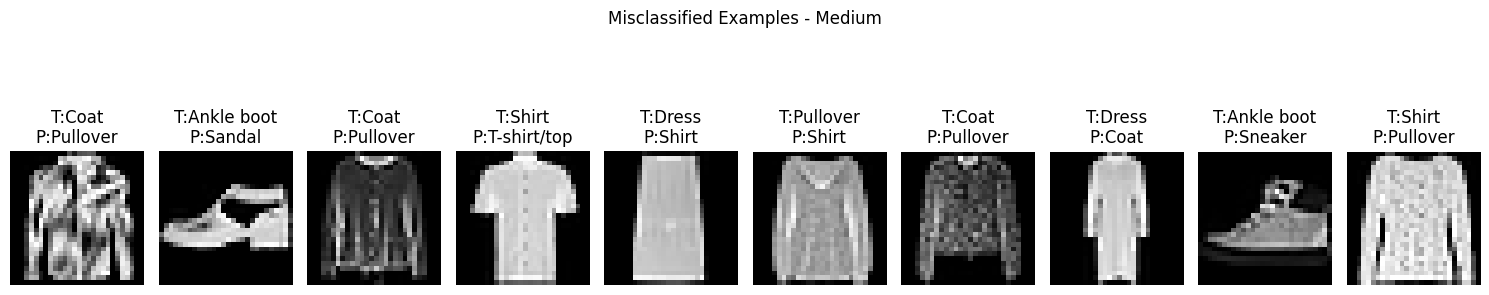

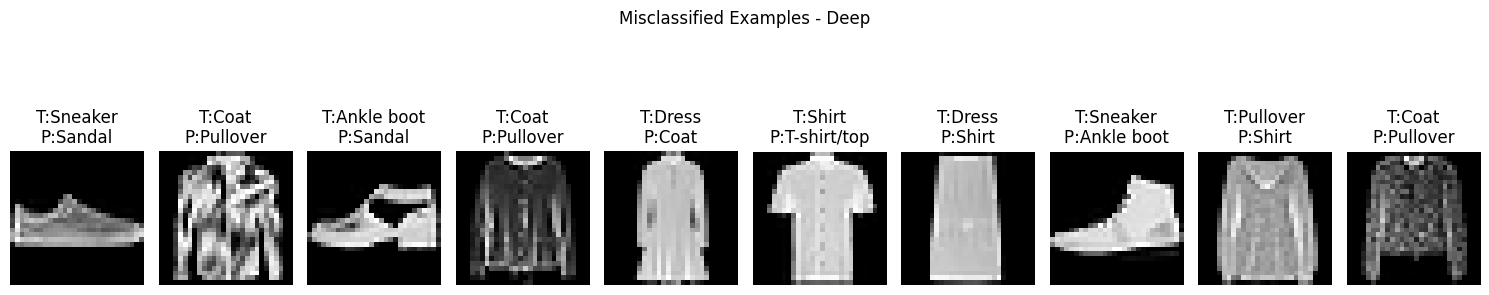

In [11]:
def show_misclassified(res,n=10):
    mis_idx = np.where(res['test_preds']!=res['test_labels'])[0]
    if len(mis_idx)==0:
        print("No misclassifications!")
        return
    n = min(n,len(mis_idx))
    plt.figure(figsize=(15,4))
    for i,idx in enumerate(mis_idx[:n]):
        img,label = test_dataset[idx]
        plt.subplot(1,n,i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"T:{class_names[label]}\nP:{class_names[res['test_preds'][idx]]}")
        plt.axis('off')
    plt.suptitle(f"Misclassified Examples - {res['name']}")
    plt.tight_layout()
    plt.show()

for res in [results_shallow, results_medium, results_deep]:
    show_misclassified(res, n=10)

# **12. Depth vs Accuracy vs Parameters**
# Compare test accuracy, number of parameters, and depth.


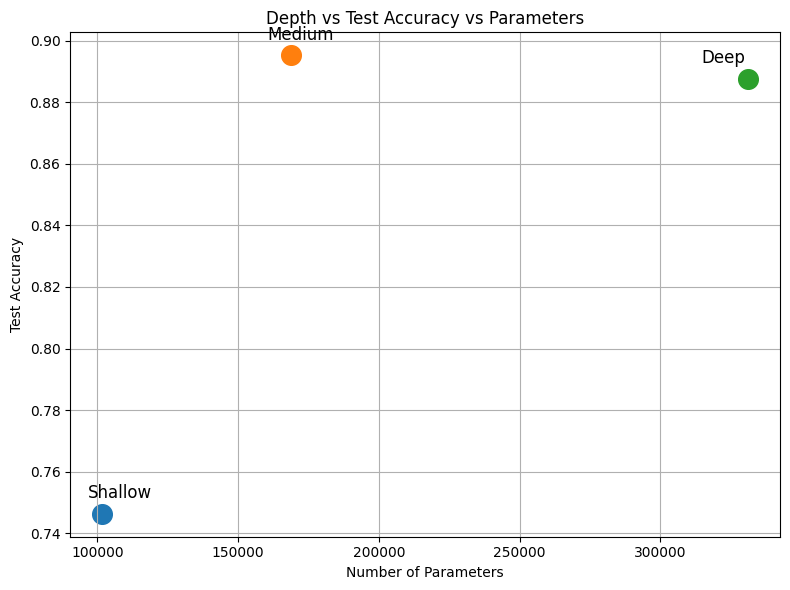

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

models = [results_shallow, results_medium, results_deep]
depth_names = [res['name'] for res in models]
test_accs = [res['test_acc'] for res in models]
param_counts = [count_parameters(shallow), count_parameters(medium), count_parameters(deep)]

plt.figure(figsize=(8,6))
for i in range(len(models)):
    plt.scatter(param_counts[i], test_accs[i], s=200, label=depth_names[i])
    plt.text(param_counts[i]*0.95, test_accs[i]+0.005, depth_names[i], fontsize=12)
plt.xlabel("Number of Parameters"); plt.ylabel("Test Accuracy")
plt.title("Depth vs Test Accuracy vs Parameters")
plt.grid(True); plt.tight_layout()
plt.savefig("figures/depth_vs_acc_params.png", dpi=300)
plt.show()


# **13. Summary Table**
# Display and save a table summarizing parameters, accuracy, and training time.


In [14]:
summary_data = []
for res, model_obj in zip(models,[shallow, medium, deep]):
    summary_data.append({
        'Model': res['name'],
        'Num Parameters': count_parameters(model_obj),
        'Test Accuracy': round(res['test_acc'],4),
        'Train Time (s)': round(res['train_time_s'],1)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df[['Model','Num Parameters','Test Accuracy','Train Time (s)']]
display(summary_df)
summary_df.to_csv("figures/summary_table.csv", index=False)
print("Saved summary_table.csv in /figures")

,Model,Num Parameters,Test Accuracy,Train Time (s)
0,Shallow,101770,0.7463,373.1
1,Medium,168734,0.8953,440.8
2,Deep,331038,0.8877,499.2


Saved summary_table.csv in /figures
